# *카메라 스티커앱 만들기*

## 학습 내용
1. 얼굴인식 카메라의 흐름 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리

## 이미지 처리 관련 패키지 불러오기

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")
print(cv2.__version__)

🌫🛸
4.1.2


#### 이미지 불러오기

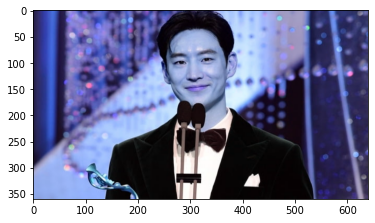

In [ ]:
import os
my_image_path = '/content/drive/MyDrive/LMS/Ex.3/img.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- 위 이미지 뭔가 이상하다.
- 외계인이 나왔다.
- 이유는 OpenCV
- OpenCV는 이미지를 BGR순으로 구성한다.
- 하여, RGB순으로 바꿔 지구인으로 변환해 줘야 한다.

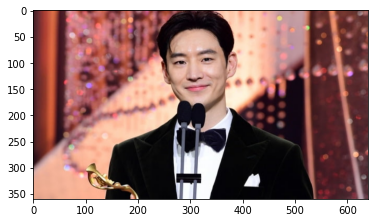

In [ ]:
 img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Face detection 진행

- face detection을 위해 dlib이란 라이브러리를 사용한다.
- dlib은 HOG(Histogram of Oriented Gradients) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

In [ ]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


- detector_hog를 이용해서 얼굴의 bounding box를 추출
- 이미지 피라미드 기법으로 upsampling 작업
- upsampling이란, 간단하게 데이터의 크기를 키우는 것

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


- Bounding Box 표시해보기

rectangles[[(259, 68) (366, 175)]]


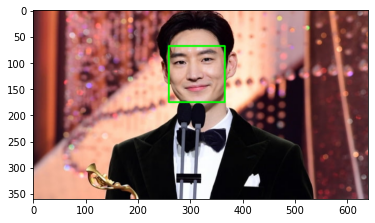

In [ ]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face landmark 검출

- Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 함.
  1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
  2.  bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

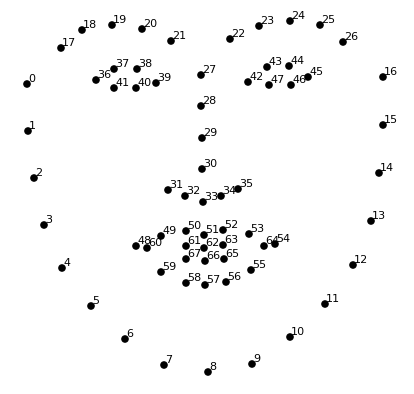

- landmark 모델 불러오기

In [ ]:
import os
model_path = '/content/drive/MyDrive/LMS/Ex.3/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


- landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


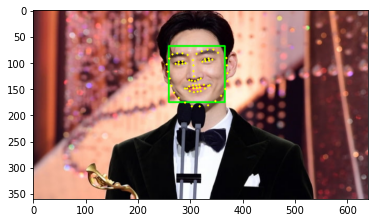

In [ ]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[13][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(307, 126)
(x,y) : (307,81)
(w,h) : (108,108)


In [ ]:
sticker_path = '/content/drive/MyDrive/LMS/Ex.3/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 108, 3)


In [ ]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (253,-27)


In [ ]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (253,0)


In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


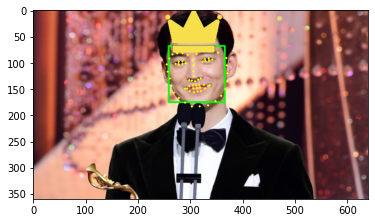

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

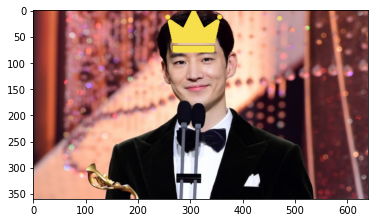

In [ ]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()